# Import relevant libraries and packages. 

In [13]:
import nidaqmx
from nidaqmx import Task
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import serial
from serial.tools import list_ports
import time
import datetime
import scipy
from scipy.optimize import curve_fit
import warnings
import os
os.getcwd()

'C:\\Users\\teachinglabsadmin\\Documents\\CHEM 174 274 fall 2021\\E3\\Friday'

# Define Functions 

Define the functions that will be used to control the syringe pump and acquire data

In [3]:
def get_device_port():
    
    """
    'get_device_port'  obtains the pump device port which is usually the highest device port

    Returns: 
        Device Port
    """
    
    #Iterate through list in reverse to get highest device COM port
    for comport in reversed(list_ports.comports()):
        device_name = comport.device
        with serial.Serial(device_name, timeout=3) as ser: 
            ser.write(b'/1?\r')
            reading=ser.read_until(b'\r')
            if(reading):
                return device_name
    raise IOError("Syringe not found")


In [4]:
def initialize_and_fill_and_expel_backlash():
    
    ''''
    This function initializes the pump and fills the syringe. 
    It then releases 1000 steps into the output syringe to remove backlash. 
    The pump must be empty before this is called. 
    '''
    
    print('filling syringe')
    
    device_port = get_device_port()
    with serial.Serial(device_port, timeout=5) as ser:
        ser.write(b'/1ZN1R\r')
        time.sleep(5)
        ser.write(b'/1IA12000R\r')
        time.sleep(5)
        ser.write(b'/1OD1000R\r')
        
        # Wait 5 seconds. We need at least 5 seconds before the syringe pump can respond to the next command
        time.sleep(5)
        

In [5]:
def expel_and_close():
    
    '''
    This function expels the untitrated amount to waste
    '''
    
    print('emptying syringe')
    
    device_port = get_device_port()
    with serial.Serial(device_port, timeout=5) as ser:
        ser.write(b'/1OA0R\r')
    
    # Wait 5 seconds. We need at least 3 seconds before the syringe pump can respond to the next command
    time.sleep(5)
    

In [6]:
def add_titrant(num_steps):
    
    '''
    This function adds some amount of titrant to the syringe. 
    
    The function takes the argument:
        num_steps = number of steps in the pump motor which detemines amount of titrant added
    '''
    print('adding titrant')
   
    device_port = get_device_port()
    to_write = '/1OD' + str(num_steps) + 'R\r'
    
    with serial.Serial(device_port, timeout=5) as ser:
        ser.write(to_write.encode('utf-8'))
    
    # Wait 5 seconds. We need at least 3 seconds before the syringe pump can respond to the next command
    time.sleep(5)
    

In [7]:
def get_potential_measurement(samp_rate, samp_num):
    
    '''
    'get_voltage_measurement' is identical to E1. Each acquisition samples the potential some number of times at some sampling rate.
    
    The function takes two arguments:
        samp_rate = rate at which data is sampled per second 
        samp_num = total number of samples in a single data aquisition
        
    and returns:
       v_m = a list of all potentials sampled in the data acquisition
        
    '''
    
    
    # get a list of devices
    all_devices = list(nidaqmx.system.System.local().devices)
    
    # throw error if no devices are found or if multiple devices are found
    if (len(all_devices) == 0):
        raise IOError("No DAQ device found")
    if (not (len(all_devices) == 1)):
        warnings.warn("More than one DAQ device found. Using the first device. \
            Manually change dev_name to use other device")
        
    # otherwise use the first device that's found
    dev_name = all_devices[0].name
    
    # collect data, assign to v_m
    with Task() as task:
        
        # add input channel and set E range ( For CHEM174/274 potentiostat E range is always [-10,10] )
        task.ai_channels.add_ai_voltage_chan(dev_name + "/ai0", max_val=10, min_val=-10)
        
        '''
        # set the input voltage range to [-1,1] (not used in A2021)
        task.ai_channels.all.ai_min = -1
        task.ai_channels.all.ai_max = 1
        '''
        
        # set sampling rate and number of samples in acquisition 
        task.timing.cfg_samp_clk_timing(samp_rate, samps_per_chan=samp_num)
        
        # collect data from daq
        v_m = task.read(samp_num, timeout=nidaqmx.constants.WAIT_INFINITELY)
        
    return v_m
    

In [8]:
def fit_func(x, m, b):
    
    '''
    This is some function used to fit the calibration data. For E3 want a linear fit for the pH calibration.
    x is the independent variable, m is the gradient, and b is a constant
    '''
    
    return m*x+b

# Section 1: Potential Measurement Using pH Probes

In this section you will be making potential measurements using the the pH probe. This will include creating a calibration curve of voltage vs pH for 3 buffer solutions of known pH. **Make sure to change the title and file name for each plot you want to save.**   

In [32]:
'''CODE BLOCK 1'''

# stores the mean and standard deviation of each potential acquisition 
mean_meas = []
std_meas = []

# x axis label for each acquisition 
sol_num = [] 

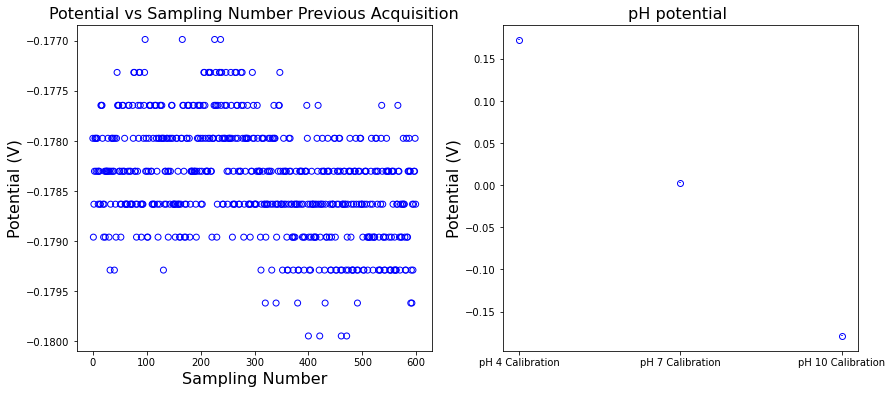

[0.172478830179777, 0.002718232570994735, -0.17839986224297638] [0.0004892423073316135, 0.0004949013695150583, 0.0005452112154405124] 



In [36]:
'''CODE BLOCK 2'''

# define x axis tick label for acquisition (can be solution concentration or anything) and append to 'sol_conc' array
acq_name = 'pH 10 Calibration'
sol_num.append(acq_name)

# define sampling rate and sampling number 
samp_rate = 600
samp_num = 600

# collect data
measured_potential = get_potential_measurement(samp_rate, samp_num)

# append mean and standard deviation of potential to 'mean_meas' and 'std_meas' which store data from all acquisitions
mean_meas.append(np.mean(measured_potential))
std_meas.append(np.std(measured_potential))

# set up subplot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

# subplot 1 
ax1.scatter(np.arange(len(measured_potential)), measured_potential, facecolors='none', edgecolors='b')
ax1.set_title('Potential vs Sampling Number Previous Acquisition', fontsize = 16)
ax1.set_xlabel('Sampling Number', fontsize = 16)
ax1.set_ylabel('Potential (V)', fontsize = 16)

# subplot 2 
ax2.errorbar(x = np.arange(len(mean_meas)), y = mean_meas , yerr = std_meas,  fmt='bo', fillstyle='none')
ax2.set_title('pH potential ', fontsize = 16)
ax2.set_ylabel('Potential (V)', fontsize = 16)
ax2.set_xticks(np.arange(0, len(sol_num))) 
ax2.set_xticklabels(sol_num) 
# plt.savefig('pH calibration')

plt.show()
print(mean_meas, std_meas, '\n')

[-0.17796632156304518] [0.0006194240970643326] 



            Solution  mean potential   std dev
0   pH 4 Calibration        0.172479  0.000489
1   pH 7 Calibration        0.002718  0.000495
2  pH 10 Calibration       -0.178400  0.000545
The calibration curve is y = -0.04971010167294109x + 0.3303330779888724
The fit covariance is [[ 2.53690585e-05 -1.69127057e-04]
 [-1.69127057e-04  1.33610375e-03]]


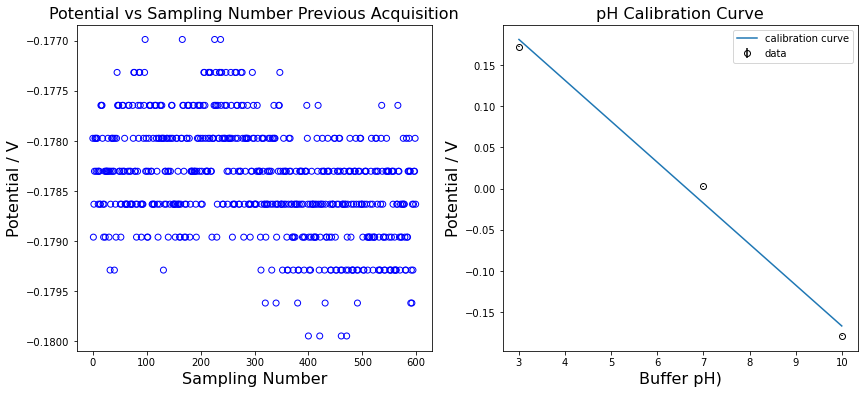

In [39]:
'''
CODE BLOCK 3

This code block does a linear fit of the data collected in Code Block 2. This will be used to create a 
calibration curve. 
'''

# pH of buffer solutions. Run the buffers in sequence
buffer_pH = np.array([3, 7, 10])

# fit buffer solution data to fit_func. fit_param is a tuple which contains the fitted variables and fit covariance
fit_param = curve_fit(fit_func, buffer_pH, mean_meas)

# set up subplot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

# subplot 1 
ax1.scatter(np.arange(len(measured_potential)), measured_potential, facecolors='none', edgecolors='b')
ax1.set_title('Potential vs Sampling Number Previous Acquisition', fontsize = 16)
ax1.set_xlabel('Sampling Number', fontsize = 16)
ax1.set_ylabel('Potential / V', fontsize = 16)

# subplot 2 

# buffer solution data
ax2.errorbar(x = buffer_pH, y = mean_meas , yerr = std_meas,  fmt='ko', 
             label ='data', fillstyle='none') 

# fitted calibration curve 
ax2.plot(buffer_pH, fit_func(buffer_pH, fit_param[0][0], fit_param[0][1]), label = 'calibration curve') 

ax2.set_title('pH Calibration Curve', fontsize = 16)
ax2.set_ylabel('Potential / V', fontsize = 16)
ax2.set_xlabel('Buffer pH)', fontsize = 16)
ax2.legend()

# Save figure in the current directory. Note this will overwrite existing images with the same filename 
plt.savefig('pH probe measurement.png', dpi = 300, bbox_inches='tight')


# save data
pH_data = pd.DataFrame({'Solution': sol_num , 'mean potential': mean_meas, 'std dev': std_meas})
print(pH_data)
pH_data.to_csv('pH probe measurement.txt', index = False)

# calibration curve fit params
print(f'The calibration curve is y = {fit_param[0][0]}x + {fit_param[0][1]}')
print(f'The fit covariance is {fit_param[1]}')





# Section 2: Calibration of KOH and Vinegar Titration

In this section you will be titrating potassium hydrogen pthalate with KOH(aq) to calibrate the KOH concentration and then titrating a sample of an unknown concentration of vinegar with the calibrated KOH. 

**Make sure to change the plot names when switching over to the vinegar titration**

In [255]:
'''
CODE BLOCK 4

rinse the syringe 
'''
# fill syringe
initialize_and_fill_and_expel_backlash()

# empty syringe
expel_and_close()

filling syringe
emptying syringe


In [256]:
"""
CODE BLOCK 5

fill the syringe and expel backlash into wash vial 
"""

# fill syringe
initialize_and_fill_and_expel_backlash()

filling syringe


In [275]:
"""
CODE BLOCK 6

initialize arrays for storing the history of steps added and potential measurements in each titration step
"""

# stores cumulative 'steps' made by the pump motor when dispensing the titrant
history_steps = []
# stores samples from each potential acquisition
all_potential_measurements = []


    step  mean potential   std dev
0      0       -0.161961  0.000338
1    200       -0.133546  0.000778
2    300       -0.114207  0.000644
3    400       -0.065852  0.001090
4    450       -0.020947  0.001000
5    500        0.007024  0.000414
6    550        0.020481  0.000331
7    600        0.029164  0.000344
8    650        0.035696  0.000979
9    700        0.040997  0.000346
10   750        0.045979  0.000380
11   800        0.050816  0.000410
adding titrant


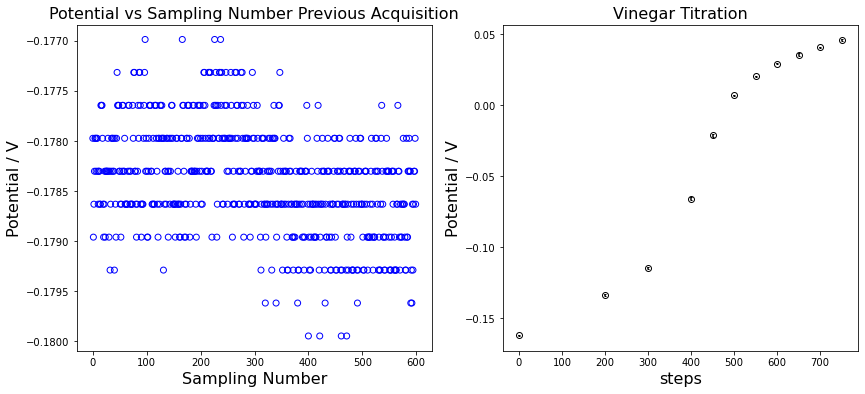

In [288]:
"""
CODE BLOCK 7

This block acquires data and plots the data from all titration steps. 
After acquiring the data, the next aliquot of titrant is dispensed. 
You will run this code block repeatedly throughout the titration

Do not rerun cell 6 before the end of the titration
"""


# parameters for potential measurements
samp_rate = 600
samp_num = 600

# Set the number of syringe steps of titrant dispensed in the next aliquot
num_steps = 50

# Check if desired amount to be dispensed exceeds syringe capacity
if len(history_steps) == 0:
    pass
# raise error if cumulative amount dispensed exceeds syringe capacity
elif (num_steps + history_steps[-1] > 11000):
        raise ValueError("Total Steps will exceed 11000. Decrease num_steps")
        
# If it's the first step, wait 5 seconds for user to immerse the tube into the liquid. 
if len(history_steps) == 0:
    history_steps.append(0)
    print('1 second delay for initial step.')
    time.sleep(1)

# take potential measurement and append data to storage arrays
curr_meas = get_potential_measurement(samp_rate, samp_num)
all_potential_measurements.append(curr_meas)

# calculate mean and standard deviation of all acquisitions
all_mean = [np.mean(meas_i) for meas_i in all_potential_measurements]
all_std = [np.std(meas_i) for meas_i in all_potential_measurements]

# plot results so far
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
# subplot 1 (sample vs potential of previous acquisiton)
ax1.scatter(np.arange(len(measured_potential)), measured_potential, facecolors='none', edgecolors='b')
ax1.set_title('Potential vs Sampling Number Previous Acquisition', fontsize = 16)
ax1.set_xlabel('Sampling Number', fontsize = 16)
ax1.set_ylabel('Potential / V', fontsize = 16)
# subplot 2 cumulative data collected at for all acquisitions
ax2.errorbar(titration_data['step'], titration_data['mean potential'], yerr=titration_data['std dev'],  fmt='ko', fillstyle='none', capsize=1)
ax2.set_title('Vinegar Titration', fontsize = 16)
ax2.set_xlabel('steps', fontsize = 16)
ax2.set_ylabel('Potential / V', fontsize = 16)

# print cumulative data collected
titration_data = pd.DataFrame({'step': history_steps , 'mean potential': all_mean, 'std dev': all_std})
print(titration_data)

# tell syringe pump to add titrant
add_titrant(num_steps)

# update cumulative total of steps added
history_steps.append(num_steps)
history_steps[-1] += history_steps[-2] 

#Save data to excel

In [278]:
print(titration_data)

   step  mean potential   std dev
0     0       -0.161961  0.000338
1   200       -0.133546  0.000778


# END TITRATION. ONLY RUN BLOCK 8 IF TITRATION IS COMPLETE

In [176]:
"""
CODE BLOCK 8

ONLY RUN WHEN TITRATION IS COMPLETE

When the titration is complete, this block makes the final potential acquisition corresponding to the last
aliquot of titrant added.
"""
# parameters for potential measurements
samp_rate = 600
samp_num = 600

# take potential measurement and append data to array 
curr_meas = get_potential_measurement(samp_rate, samp_num)
all_potential_measurements.append(curr_meas)

# calculate mean and standard deviation of all acquisitions
all_mean = [np.mean(meas_i) for meas_i in all_potential_measurements]
all_std = [np.std(meas_i) for meas_i in all_potential_measurements]
print(len(all_mean))


In [177]:
all_mean = all_mean[:-2]
all_std = all_std[:-2]
print(len(all_mean))

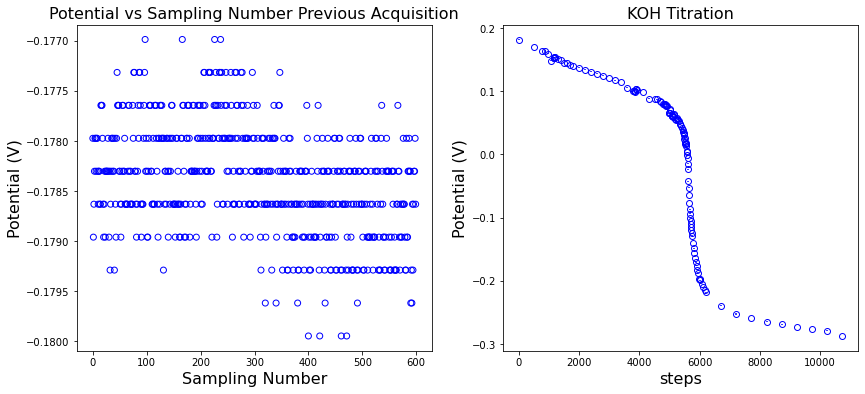

In [184]:
"""
CODE BLOCK 9

Complete titration. Replot then save titration plot and data. Make sure to name the data file and image files
appropriately

# """

# plot results so far and save it. Make sure to change the image name for the second titration 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
# subplot 1 (sample vs potential of previous acquisiton)
ax1.scatter(np.arange(len(measured_potential)), measured_potential, facecolors='none', edgecolors='b')
ax1.set_title('Potential vs Sampling Number Previous Acquisition', fontsize = 16)
ax1.set_xlabel('Sampling Number', fontsize = 16)
ax1.set_ylabel('Potential (V)', fontsize = 16)
# subplot 2 cumulative data collected at for all acquisitions
ax2.errorbar(titration_data['step'], titration_data['mean potential'], yerr=titration_data['std dev'],  fmt='bo', fillstyle='none')
ax2.set_title('KOH Titration', fontsize = 16)
ax2.set_xlabel('steps', fontsize = 16)
ax2.set_ylabel('Potential (V)', fontsize = 16)

# Save figure in the current directory. Note this will overwrite existing images with the same filename 
plt.savefig('troubleshooter.png', dpi = 300, bbox_inches='tight')

# Save titration data as txt. Make sure to change the name for each titration
titration_data.to_csv('KOH titration.txt', index = False)


# Section 3 Back titration of Vinegar with 0.1M HCl

In this section you will be back titrating the solution obtained at the end of the vinegar titration with 0.1M HCl. 

In [208]:
'''
CODE BLOCK 10

rinse the syringe 
'''
# fill syringe
initialize_and_fill_and_expel_backlash()

# empty syringe
expel_and_close()

filling syringe
emptying syringe


In [209]:
"""
CODE BLOCK 11

fill the syringe and expel backlash into wash vial 
"""

# fill syringe
initialize_and_fill_and_expel_backlash()

filling syringe


In [265]:
'''
DON'T RUN ME DEAR GOD
'''

# stores cumulative 'steps' made by the pump motor when dispensing the titrant
# rhistory_steps = history_steps
# # stores samples from each potential acquisition
# rall_potential_measurements = all_potential_measurements

rtitration_data = pd.read_excel('Back titration.xlsx')

In [268]:
"""
CODE BLOCK 13

This block acquires data, then plots the data from all titration steps. 
After acquiring the data, the next aliquot of titrant is dispensed. 
This code block will be run repeatedly throughout the titration

Do not rerun cell 12 before the end of the titration

"""

# parameters for potential acquisition
# samp_rate = 600
# samp_num = 600

# # define step size or the amount of titrant dispensed in each step
# num_steps = 600

# # If it's the first step, wait 5 seconds for user to immerse the tube into the liquid. 
# if len(rhistory_steps) == 0:
#     rhistory_steps.append(history_steps[-1])
#     print('5 second delay for initial step')
#     time.sleep(5)

# take potential measurement and append data to storage arrays
rcurr_meas = get_potential_measurement(samp_rate, samp_num)
rall_potential_measurements.append(rcurr_meas)

# calculate mean and standard deviation of all acquisitions
rall_mean = [np.mean(meas_i) for meas_i in rall_potential_measurements]
rall_std = [np.std(meas_i) for meas_i in rall_potential_measurements]

# plot results so far 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
# subplot 1 (sample vs potential of previous acquisiton)
ax1.scatter(np.arange(len(measured_potential)), measured_potential, facecolors='none', edgecolors='b')
ax1.set_title('Potential vs Sampling Number Previous Acquisition', fontsize = 16)
ax1.set_xlabel('Sampling Number', fontsize = 16)
ax1.set_ylabel('Potential (V)', fontsize = 16)
# subplot 2 cumulative data collected at for all acquisitions
ax2.errorbar(titration_data['step'], titration_data['mean potential'], yerr=titration_data['std dev'],  fmt='ro', fillstyle='none', label = 'reverse')
ax2.errorbar(rtitration_data['step'], rtitration_data['mean potential'], yerr=rtitration_data['std dev'],  fmt='bo',fillstyle='none', label = 'forward')
ax2.set_title('Vinegar Back Titration', fontsize = 16)
ax2.set_xlabel('steps', fontsize = 16)
ax2.set_ylabel('Potential (V)', fontsize = 16)
ax2.legend()

# print cumulative data collected
rtitration_data = pd.DataFrame({'reverse step': rhistory_steps , 'mean potential': rall_mean, 'std dev': rall_std})
print(titration_data)

# tell syringe pump to add titrant
add_titrant(num_steps)

# get a cumulative total of reversed steps
rhistory_steps.append(-1*num_steps)
rhistory_steps[-1] += rhistory_steps[-2] 


ValueError: arrays must all be same length

# END TITRATION. ONLY RUN BLOCK 14 IF TITRATION IS COMPLETE

In [45]:
"""
CODE BLOCK 14

ONLY RUN WHEN TITRATION IS COMPLETE

When the titration is complete, make the final potential acquisition corresponding to the last aliquot of 
titrant added

"""

# parameters for potential acquisition
samp_rate = 600
samp_num = 600

# take voltage measurement
rcurr_meas = get_potential_measurement(samp_rate, samp_num)
rall_potential_measurements.append(rcurr_meas)

# append data to arrays
rall_mean = [np.mean(meas_i) for meas_i in rall_potential_measurements]
rall_std = [np.std(meas_i) for meas_i in rall_potential_measurements]

   reverse step  mean potential   std dev
0           300        0.188738  0.000528
1           200        0.188837  0.000477
2           100        0.188464  0.001028
3             0        0.190003  0.000552


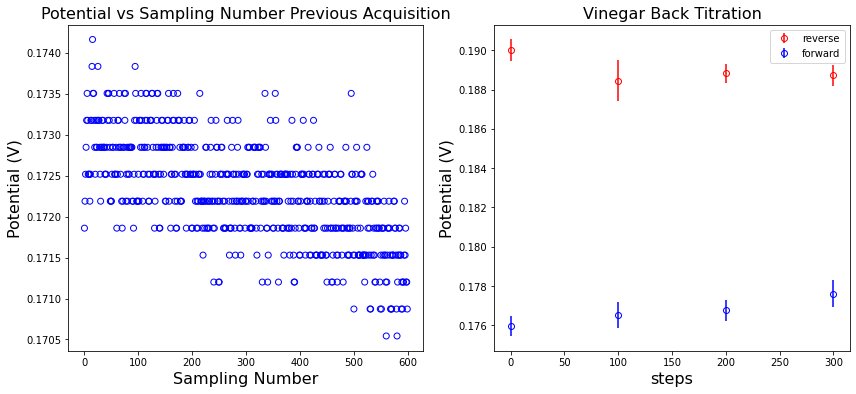

In [47]:
"""
CODE BLOCK 15

Replot then save titration plot and data. Make sure to name the data file and image files appropriately

"""

# plot results so far and save it. Make sure to change the image name for the second titration 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))
# subplot 1 (sample vs potential of previous acquisiton)
ax1.scatter(np.arange(len(measured_potential)), measured_potential, facecolors='none', edgecolors='b')
ax1.set_title('Potential vs Sampling Number Previous Acquisition', fontsize = 16)
ax1.set_xlabel('Sampling Number', fontsize = 16)
ax1.set_ylabel('Potential (V)', fontsize = 16)
# subplot 2 cumulative data collected at for all acquisitions
ax2.errorbar(rhistory_steps, rall_mean, yerr=rall_std,  fmt='ro', fillstyle='none', label = 'reverse')
ax2.errorbar(history_steps, all_mean, yerr=all_std,  fmt='bo', fillstyle='none', label = 'forward')
ax2.set_title('Vinegar Back Titration', fontsize = 16)
ax2.set_xlabel('steps', fontsize = 16)
ax2.set_ylabel('Potential (V)', fontsize = 16)
ax2.legend()

# Save figure in the current directory. Note this will overwrite existing images with the same filename 
plt.savefig('Vinegar back titration.png', dpi = 300, bbox_inches='tight')

# Save titration data as txt. Make sure to change the name for each titration
titration_data.to_csv('Vinegar Back Titration.txt', index = False)

# print cumulative data collected
titration_data = pd.DataFrame({'reverse step': rhistory_steps , 'mean potential': rall_mean, 'std dev': rall_std})
print(titration_data)

# Save titration data as txt. Make sure to change the name for each titration
titration_data.to_csv('back titration.txt', index = False)

# Section 4: Pump Calibration

In this section you will gravimetrically calibrate the amount of titrant dispensed. 

In [ ]:
"""
CODE BLOCK 16

Measure mass of titrant dispensed 
"""

# fill syringe
initialize_and_fill_and_expel_backlash()
# tell syringe pump to add titrant
add_titrant(6000)

In [ ]:
"""
CODE BLOCK 17

Clean syringe
"""

# fill syringe
initialize_and_fill_and_expel_backlash()
# empty syringe
expel_and_close()
